In [100]:
#“I certify that this assignment represents my work. I have not used any unauthorized or unacknowledged assistance 
#or sources in completing it, including free or commercial systems or services offered on the internet.”

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import models
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_selection import mutual_info_classif
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.metrics import make_scorer, accuracy_score

import multiprocessing
import re

In [102]:
import pandas as pd

# read data
reviews_df = pd.read_csv('deception_data_converted.txt',sep='\t',encoding='iso-8859-1')
reviews_df.head()

,lie,sentiment,review
0,fake,negative,"'Mike\'s Pizza High Point, NY Service was very..."
1,fake,negative,'i really like this buffet restaurant in Marsh...
2,fake,negative,"'After I went shopping with some of my friend,..."
3,fake,negative,'Olive Oil Garden was very disappointing. I ex...
4,fake,negative,'The Seven Heaven restaurant was never known f...


In [103]:
reviews_df.shape

(92, 3)

In [104]:
reviews_df['lie'].value_counts()

fake    46
true    46
Name: lie, dtype: int64

In [105]:
reviews_df['sentiment'].value_counts()

negative    46
positive    46
Name: sentiment, dtype: int64

In [106]:
import arff
arff.dump('product_review.arff'
       , reviews_df.values
       , relation='relation name'
       , names=reviews_df.columns)

In [107]:
# we don't include stem
def text_process(document, rebuild_document=True):
    import re
    words = []
    
    for sentence in sent_tokenize(document):
        tokens = [wordnet_lemmatizer.lemmatize(t.lower())
        for t in regexp_tokenizer.tokenize(sentence) if t.lower() not in stop_words]
        words += tokens

    if rebuild_document:
        #### rebuild the sentence
        content = ' '.join(words).strip()

        content = content.replace(r"'"," ")
        content = re.sub('s\+', ' ', content)
        content = content.strip()
        
        return content
    else:
        return words

In [108]:

reviews_categories = {
    'true': 0,
    'fake': 1}

reviews_X = []
token_reviews_X = []
reviews_Y = []

In [109]:
# load stop-words
stop_words = set(stopwords.words('english'))

# initialize tokenizer
regexp_tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# initialize stemmer
porter_stemmer = PorterStemmer()

In [110]:
for index, row in reviews_df.iterrows():
    category = row.lie
    text = row.review

    category_idx = reviews_categories[category]

    reviews_X.append(text_process(text))
    token_reviews_X.append(text_process(text,False))
    reviews_Y.append(category_idx)

In [111]:
##LIE DETECTION USING word2vec
google_word2vec = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [112]:
from collections import defaultdict
import numpy as np

dim = 0

if len(google_word2vec) > 0:
    dim=len(next(iter(google_word2vec)))
else:
    dim=0

word2vec_reviews_X = np.array([
    np.mean([google_word2vec[w] for w in words if w in google_word2vec]
        or [np.zeros(dim)], axis=0)
    for words in token_reviews_X
    ])

In [113]:
X_train, X_test, Y_train, Y_test = train_test_split(word2vec_reviews_X, reviews_Y, test_size=0.25, random_state=1)


In [114]:
#Minmax scaler to scale data to 0 to 1 for naive bayes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [115]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs))

/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_25859/3696085333.py:7: RuntimeWarning: divide by zero encountered in log2
  split_information = -np.sum(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])*np.log2(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])))
/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_25859/3696085333.py:7: RuntimeWarning: invalid value encountered in multiply
  split_information = -np.sum(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])*np.log2(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])))


Feature 299: Gain ratio = nan
Feature 93: Gain ratio = nan
Feature 95: Gain ratio = nan
Feature 96: Gain ratio = nan
Feature 97: Gain ratio = nan
Feature 98: Gain ratio = nan
Feature 99: Gain ratio = nan
Feature 100: Gain ratio = nan
Feature 101: Gain ratio = nan
Feature 102: Gain ratio = nan
Feature 103: Gain ratio = nan
Feature 104: Gain ratio = nan
Feature 105: Gain ratio = nan
Feature 106: Gain ratio = nan
Feature 107: Gain ratio = nan


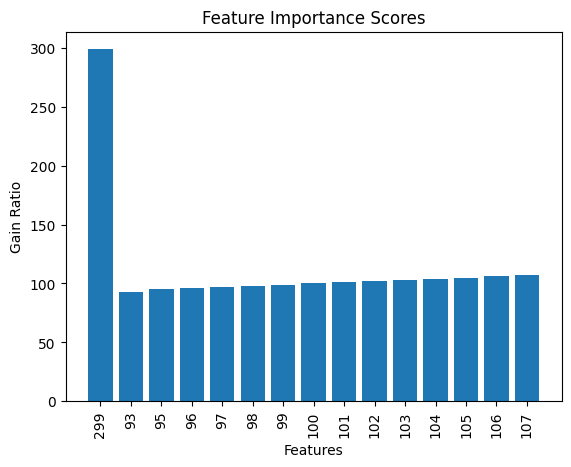

In [116]:
#General GainRatio
mutual_info = mutual_info_classif(X_train_scaled, Y_train)
total_entropy = entropy(Y_train)
gain_ratios = []
for i in range(X_train_scaled.shape[1]):
    feature_entropy = entropy(X_train_scaled[:,i])
    split_information = -np.sum(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])*np.log2(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])))
    gain_ratios.append((mutual_info[i]/feature_entropy)/split_information)

# print the gain ratios for top 15 features
top_features_idx = np.argsort(gain_ratios)[::-1][:15]
for idx in top_features_idx:
    print(f"Feature {idx}: Gain ratio = {gain_ratios[idx]}")

plt.bar(range(len(top_features_idx)), top_features_idx)
plt.xticks(range(len(top_features_idx)), top_features_idx, rotation=90)
plt.title("Feature Importance Scores")
plt.xlabel("Features")
plt.ylabel("Gain Ratio")
plt.show()

In [117]:
#Vanilla Multinomial
model = MultinomialNB()
model.fit(X_train_scaled, Y_train)
y_pred=model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))


accuracy: 0.30434782608695654
F1 score: 0.29230769230769227


In [118]:
#Multinomial NB
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [0.001, 0.002,0.003,0.004,0.005,0.01, 0.09,0.05, 0.75, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
print("Parameter grid:\n{}".format(param_grid))

mnb_grid_search = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=10,scoring="roc_auc",n_jobs=multiprocessing.cpu_count(),verbose=1)
mnb_grid_search.fit(X_train_scaled, Y_train)

mnb_best = mnb_grid_search.best_estimator_
mnb_best.fit(X_train_scaled,Y_train)
print('Best model: %s' % str(mnb_grid_search.best_params_))
print('Best score: %f' % mnb_grid_search.best_score_)
print('Best test auc: %f' % mnb_best.score(X_test_scaled,Y_test))

y_pred = mnb_best.predict(X_test_scaled)
y_prob = mnb_best.predict_proba(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)


Parameter grid:
{'alpha': [0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.09, 0.05, 0.75, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best model: {'alpha': 0.001}
Best score: 0.491667
Best test auc: 0.304348
accuracy: 0.30434782608695654
F1 score: 0.29230769230769227
Accuracy: 0.30434782608695654


In [119]:
selector = SelectKBest(mutual_info_classif, k=15)

X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
mnb_best.fit(X_train_new,Y_train)
y_pred = mnb_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[  8  18  21  22  93 115 122 137 155 166 188 196 199 241 274]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [120]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [121]:
#standardscaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [122]:
#Vanilla SVC
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.391304347826087
F1 score: 0.28125


In [123]:
from sklearn.svm import SVC

param_grid = {
    'kernel': ['linear','rbf','poly'],
    'C': [0.1,1,2,3,4,5,10,20,30,40,50,60,70,100],
    'gamma': [0.1, 0.01, 0.001,1,10]
}
print("Parameter grid:\n{}".format(param_grid))
svc_vec_gs = GridSearchCV(estimator=SVC() , param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

svc_vec_gs.fit(X_train_scaled, Y_train)

svc_vec_best = svc_vec_gs.best_estimator_
svc_vec_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(svc_vec_gs.best_params_))
print('Best score: %f' % svc_vec_gs.best_score_)
print('Best test auc: %f' % svc_vec_best.score(X_test_scaled,Y_test))

y_pred = svc_vec_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'kernel': ['linear', 'rbf', 'poly'], 'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 100], 'gamma': [0.1, 0.01, 0.001, 1, 10]}
Fitting 10 folds for each of 210 candidates, totalling 2100 fits
Best model: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best score: 0.611111
Best test auc: 0.391304
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
selector = SelectKBest(mutual_info_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
svc_vec_best.fit(X_train_new,Y_train)
y_pred = svc_vec_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[  8  18  21  22  93 115 122 137 155 166 188 196 199 241 274]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [125]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [126]:
#Vanilla random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.391304347826087
F1 score: 0.28125


In [127]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3,5,7,9],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_samples_split': [15, 20, 30]
}
print("Parameter grid:\n{}".format(param_grid))
random_gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

random_gs.fit(X_train_scaled, Y_train)

random_best = random_gs.best_estimator_
random_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(random_gs.best_params_))
print('Best score: %f' % random_gs.best_score_)
print('Best test auc: %f' % random_best.score(X_test_scaled,Y_test))

y_pred = random_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'bootstrap': [True, False], 'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [10, 20, 30, 50], 'min_samples_split': [15, 20, 30]}
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best model: {'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 30}
Best score: 0.722222
Best test auc: 0.347826
accuracy: 0.34782608695652173
F1 score: 0.34285714285714286
Accuracy: 0.34782608695652173


In [128]:
selector = SelectKBest(mutual_info_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
random_best.fit(X_train_new,Y_train)
y_pred = random_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[  8  18  21  22  93 115 122 137 155 166 188 196 199 241 274]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [129]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [150]:
##SENTIMENT DETECTION USING word2vec_VECTORIZER
reviews_categories = {
    'negative': 0,
    'positive': 1}

reviews_X = []
token_reviews_X = []
reviews_Y = []

In [151]:
# load stop-words
stop_words = set(stopwords.words('english'))

# initialize tokenizer
regexp_tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# initialize stemmer
porter_stemmer = PorterStemmer()

In [152]:
for index, row in reviews_df.iterrows():
    category = row.sentiment
    text = row.review

    category_idx = reviews_categories[category]

    reviews_X.append(text_process(text))
    token_reviews_X.append(text_process(text,False))
    reviews_Y.append(category_idx)

In [153]:
###SENTIMENT DETECTION USING WORD2VEC
google_word2vec = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [154]:
from collections import defaultdict
import numpy as np

dim = 0

if len(google_word2vec) > 0:
    dim=len(next(iter(google_word2vec)))
else:
    dim=0

word2vec_reviews_X = np.array([
    np.mean([google_word2vec[w] for w in words if w in google_word2vec]
        or [np.zeros(dim)], axis=0)
    for words in token_reviews_X
    ])

In [155]:
X_train, X_test, Y_train, Y_test = train_test_split(word2vec_reviews_X, reviews_Y, test_size=0.25, random_state=1)


In [156]:
#Minmax scaler to scale data to 0 to 1 for naive bayes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [157]:
#Vanilla Multinomial
model = MultinomialNB()
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))


accuracy: 0.391304347826087
F1 score: 0.28125


In [158]:
#Multinomial NB
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
print("Parameter grid:\n{}".format(param_grid))

mnb_grid_search = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=10,scoring="roc_auc",n_jobs=multiprocessing.cpu_count(),verbose=1)
mnb_grid_search.fit(X_train_scaled, Y_train)

mnb_best = mnb_grid_search.best_estimator_
mnb_best.fit(X_train_scaled,Y_train)
print('Best model: %s' % str(mnb_grid_search.best_params_))
print('Best score: %f' % mnb_grid_search.best_score_)
print('Best test auc: %f' % mnb_best.score(X_test_scaled,Y_test))

y_pred = mnb_best.predict(X_test_scaled)
y_prob = mnb_best.predict_proba(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)


Parameter grid:
{'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best model: {'alpha': 0.001}
Best score: 0.888889
Best test auc: 1.000000
accuracy: 1.0
F1 score: 1.0
Accuracy: 1.0


In [160]:
from sklearn.feature_selection import SelectKBest, chi2,f_classif,mutual_info_classif
selector = SelectKBest(f_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
random_best.fit(X_train_new,Y_train)
y_pred = random_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[ 38  42  46  50  51 105 119 120 146 163 168 193 224 230 236]
accuracy: 0.6086956521739131
F1 score: 0.3783783783783784
Accuracy: 0.6086956521739131
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [140]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [141]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
#Vanilla SVC
model = SVC(kernel='linear')
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.6086956521739131
F1 score: 0.3783783783783784


In [161]:
from sklearn.svm import SVC

param_grid = {
    'kernel': ['linear','rbf'],
    'C': [1,10,20,50,100],
    'gamma': [0.1, 0.01, 0.001]
}
print("Parameter grid:\n{}".format(param_grid))
svc_vec_gs = GridSearchCV(estimator=SVC() , param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

svc_vec_gs.fit(X_train_scaled, Y_train)

svc_vec_best = svc_vec_gs.best_estimator_
svc_vec_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(svc_vec_gs.best_params_))
print('Best score: %f' % svc_vec_gs.best_score_)
print('Best test auc: %f' % svc_vec_best.score(X_test_scaled,Y_test))

y_pred = svc_vec_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'kernel': ['linear', 'rbf'], 'C': [1, 10, 20, 50, 100], 'gamma': [0.1, 0.01, 0.001]}
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best model: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Best score: 0.933333
Best test auc: 0.956522
accuracy: 0.9565217391304348
F1 score: 0.9551656920077973
Accuracy: 0.9565217391304348


In [164]:
selector = SelectKBest(mutual_info_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
svc_vec_best.fit(X_train_new,Y_train)
y_pred = svc_vec_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[ 29  42  45  51  73  78  90 105 120 124 169 183 188 224 230]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [145]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [146]:
#Vanilla random forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.391304347826087
F1 score: 0.28125


In [165]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3,5,7,9],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_samples_split': [15, 20, 30]
}
print("Parameter grid:\n{}".format(param_grid))
random_gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

random_gs.fit(X_train_scaled, Y_train)

random_best = random_gs.best_estimator_
random_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(random_gs.best_params_))
print('Best score: %f' % random_gs.best_score_)
print('Best test auc: %f' % random_best.score(X_test_scaled,Y_test))

y_pred = random_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'bootstrap': [True, False], 'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [10, 20, 30, 50], 'min_samples_split': [15, 20, 30]}
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best model: {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 15}
Best score: 0.933333
Best test auc: 0.869565
accuracy: 0.8695652173913043
F1 score: 0.8654970760233919
Accuracy: 0.8695652173913043


In [166]:
selector = SelectKBest(mutual_info_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
random_best.fit(X_train_new,Y_train)
y_pred = random_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[ 29  42  45  51  73  78  90 105 120 124 169 183 188 224 230]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [149]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.